# Applying Adaptive Optics with Turbulence
<font color='purple' size='4px' face='Georgia'>In this __`hcipy`__ implementation we will explore how to create atmospheric turbulence, pass the field through turbulence, then on deformable mirror and sensed by a webfront sensor and apply correction to deformable mirror through feedback to correct the aberration caused by atmospheric turbulence.</font>

In [1]:
import sys
sys.path.insert(1, '../../hcipy')

from hcipy import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# declare -a RX_DIAMETER=(75 25 150) 
# declare -a TX_DIAMETER=(75 25 150)  	
# Profile_select=(1 2 3)
# Spec_Ind=0
# WAVELENGTH="1550e-9" 		# The wavelength to be considered
# DISTANCE="30e3"             # The distance from Alice to Bob, in km
# L="8"                       # The side length of the simulated window
# M="4096"                    # The number of samples along a side of the simulated window

# TRIAL_START=1
# TRIAL_STEP=100
# TRIAL_STOP=100

# PITCH="12.5e-6"				# The offset the source is from the optical axis, in m
# FOCUS="0e-6"				# The offset of the source from the focal point of the TX lens, in m


# SP_x=("${SP_x4[@]}")		# To use a custom array of points use the following form SP_x=(x1 x2 ...xN)
# SP_y=("${SP_y4[@]}")		# This array will be unitless, and the value of PITCH and Focus will scale for units accordingly
# SP_f=("${SP_f4[@]}")		# The Predefined values correspond to the square arrays with x number of points


# AO_TYPE="1"					# If AO_Type = 0, No AO is used, AO_Type = 1, Rx AO is used, AO_Type = 2, Tx AO is used, AO_Type = 3, Rx&Tx AO is used,
# AO_Guide="4"
# AO_Wavelength="1550e-9"     # The wavelength of the guide beam to be used for applying correction
# ZERN="56"					# The number of Zernikies used for reconstructing the wavefront
# ACTU="12"					# The number of Actuator on the deformable mirror
# LENS="12"					# The number of lenslets on the wavefront sensor
# WIND="0"					# The speed of the wind in the horizontal direction over the path
# LATE="0"					# The delay between the WFS detecting the wavefront and the DM moving its actuators

# AO_Guide_Con=1				# If this is set to 1 and AO_Guide is 1, the Guide Position will be the conjugate of the source position
							# This should only really be used for Tx AO,  

# AO_PITCH="12.5e-6"			# The offset the source is from the optical axis, in m
# AO_FOCUS="0e-6"				# The offset of the source from the focal point of the TX lens, in m

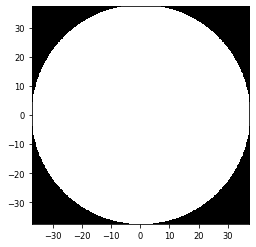

In [4]:
RX_DIAMETER = 75 # meter
WAVELENGTH = 1550e-9 # The wavelength
M = 512 # The number of samples along a side of simulated window

pupil_grid = make_pupil_grid(M, RX_DIAMETER)
aperture = circular_aperture(RX_DIAMETER)(pupil_grid)

imshow_field(aperture, cmap='gray')




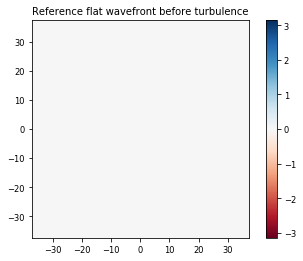

In [5]:
# Reference flat wavefront before turbulence
wf = Wavefront(aperture,WAVELENGTH)
wf.total_power = 1
imshow_field(wf.phase, vmin=-np.pi, vmax=np.pi, cmap='RdBu'); plt.title("Reference flat wavefront before turbulence"); plt.colorbar()


In [6]:
FOV = 16 # in lambda/D
n_samples_per_lambda_D = 8

focal_grid = make_focal_grid(pupil_grid, n_samples_per_lambda_D, FOV)
prop = FraunhoferPropagator(pupil_grid, focal_grid)


/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  after removing the cwd from sys.path.


## Construct Atmospheric Layer Phasescreen

In [7]:
fried_parameter = 0.2 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec

Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)


For each layer, its strength ($C_n^2$ value), outer scale ($L_0$) and velocity can be changed. The InfiniteAtmosphericLayer class even supports on-the-fly changes to these values, allowing for non-stationary turbulence simulations. We can retrieve the phase at a certain wavelength as:

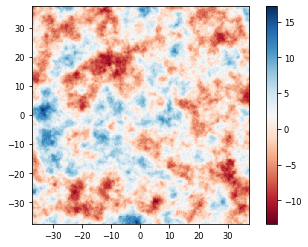

In [11]:
imshow_field(layer.phase_for(WAVELENGTH), cmap='RdBu')
plt.colorbar()
plt.show()

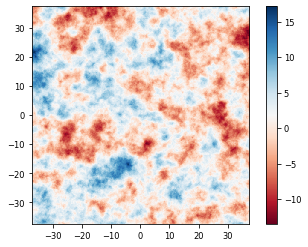

In [20]:
# Phasescreen change in two seconds
layer.t = 2.0
imshow_field(layer.phase_for(WAVELENGTH), cmap='RdBu')
plt.colorbar()
plt.show()

## Now we will pass the flat field through atmospheric turbulence

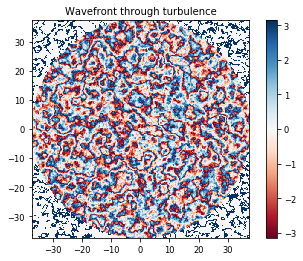

In [21]:
phase_due_to_turbulence = layer.phase_for(WAVELENGTH)
e_field = Field(np.exp(1j * phase_due_to_turbulence), pupil_grid)
wf_turbulence = Wavefront(e_field * aperture, WAVELENGTH)
wf_turbulence.total_power=1

imshow_field(wf_turbulence.phase, vmin=-np.pi, vmax=np.pi, cmap='RdBu');
plt.title("Wavefront through turbulence");
plt.colorbar()


### OKAY, this is weird and wrong that even after passing the wavefront through an aperture, phase have non-zero values outside aperture in the above figure.

In [23]:
## Calculate the wavefront's root mean sqaure error
wf_turbulence_rms = np.sqrt(np.mean(np.square(wf_turbulence.phase))-
                           
                           np.square(np.mean(wf_turbulence.phase)))

print('RMS Wavefront Error of turbulenct wavefron is {}'.format(wf_turbulence_rms))

RMS Wavefront Error of turbulenct wavefron is 1.7782214193090835


## Now we want to propagate the turbulent wavefront upto distance z


In [24]:
propagated_wavefront = prop.forward(wf_turbulence)

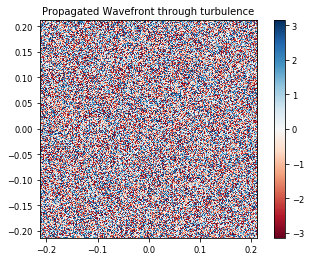

In [26]:
imshow_field(propagated_wavefront.phase, vmin=-np.pi, vmax=np.pi, cmap='RdBu');
plt.title("Propagated Wavefront through turbulence");
plt.colorbar()

(-5, 0.1)

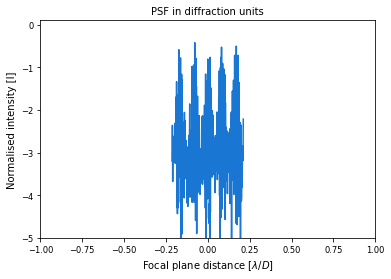

In [30]:
# Point Spread Function / Intensity
psf = propagated_wavefront.intensity
psf_shape = psf.shaped.shape
slicefoc = psf.shaped[:,psf_shape[0]//2]

slicefoc_normalised = slicefoc / psf.max()


plt.plot(focal_grid.x.reshape(psf_shape)[0,:], np.log10(slicefoc_normalised))
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Normalised intensity [I]')
plt.title('PSF in diffraction units')
plt.xlim(-1.0,1.0)
plt.ylim(-5,0.1)